# DSCI 100 Project Final Report - Group 15

## Introduction

For this data science project, a Computer Science research group at UBC, led by Frank Wood, has set up a Minecraft server to collect data on player behaviour to study how people play video games. In particular, the researchers collected data on the players' ages, gender, experience level, subscription status to the game-related newsletter, and the total number of hours played on the server. This led us to question: **Can the age, playtime, gender and experience of a user be used to predict whether or not they will subscribe to a game-related newsletter?**

To explore this question, we will be using the players.csv dataeset, which 


In [ ]:
# Libraries used/ Run before everything else!
library(tidyverse)
library(repr)
library(tidymodels)

In [2]:
players_data <- read.csv("players.csv")

Methods and Results

We first tidied our data by removing unessecary columns to our anaylsis; hashed_email and name. 
The next step was to turn categorical variables to numerical. for the experience column, this was done following the natural order of the categories( beginner = 0, amateur =1 ,regular = 2,  veteran =3 pro =4). Gender was separated into male and non-male because the other gender categories had very little data and a followed a similar trend. The Age and hours played columns are already numerical so no change was necessary. The outcome variable is the subscribe column and FALSE is set to =0, and TRUE to =1. 

We then created a recipe with subscribe as the as the outcome, and played_hours, Age, Experience, and gender as the predictors. 
The scaling and normalizing step ensures all data is standaridized for the Euciliean distance calculation. 

We preformed a double split, 80% training data and 20% testing. 

Now we set up the KNN classification model, setting neighbors to tune so that k is changeable. 

The following step created a 5-fold cross validation object and then combined recipe and model into a workflow. Next we preformed cross validation to see how our model will perform on the data. 

Using the best k, which was ___, we 







In [ ]:
#loads data

In [ ]:
#wrangling

In [5]:
<<<<<<< LOCAL CELL DELETED >>>>>>>
#wrangling
players_data <- mutate(players_data, experience = as.factor(experience))
#changing experiece from character string to factor
players_data

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<fct>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<int>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17
Regular,TRUE,8e594b8953193b26f498db95a508b03c6fe1c24bb5251d392c18a0da9a722807,0.0,Luna,Female,19
Amateur,FALSE,1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd,0.0,Emerson,Male,21
Amateur,TRUE,8b71f4d66a38389b7528bb38ba6eb71157733df7d1740371852a797ae97d82d1,0.1,Natalie,Male,47


In [ ]:
#summary

We can see our data is tidy, every row an observation, every coloumn a variable, and every cell is filled (except for some NA's in Age). There are 196 players in total.

We have seven variables: "experience" "subscribe" "hashedEmail" "played_hours" "name" "gender" "Age"

-Experience is a class with a range of "Beginner, Amateur, Regular, Veteren, Pro"

-Subscribe is a boolean (True or False) that shows if they have subscribed to a game-related newsletter or not, this is our main predicitive focus.

-HashedEmail is a character string that shows an encoded identifier, no useful for us but essential if contact with the person is needed.

-Played hours is a dbl, a decimal number with one decimal of precision, and is how many hours were played on the study's server.

-Name is a character string and is the first name of the person.

-Gender is also a character string and is the gender of the person, we will treat it as a class, Male and Other.

-Age is a dbl but has no decimal places in the data and is treated as an integer, it is the age of the person.


In [ ]:
#exploratory visualization/graphs

#Plotting experience versus subscriptions
experience_plot <- players|>
  ggplot(aes(x = experience, color = subscribe)) +
  geom_bar() +
  labs(x = "Experience (Class)",
       color = "Newsletter Subscription") +
  scale_color_manual(values = c("darkRed", "lightblue")) +
  theme(text = element_text(size = 10))

experience_plot

In [ ]:
#analysis

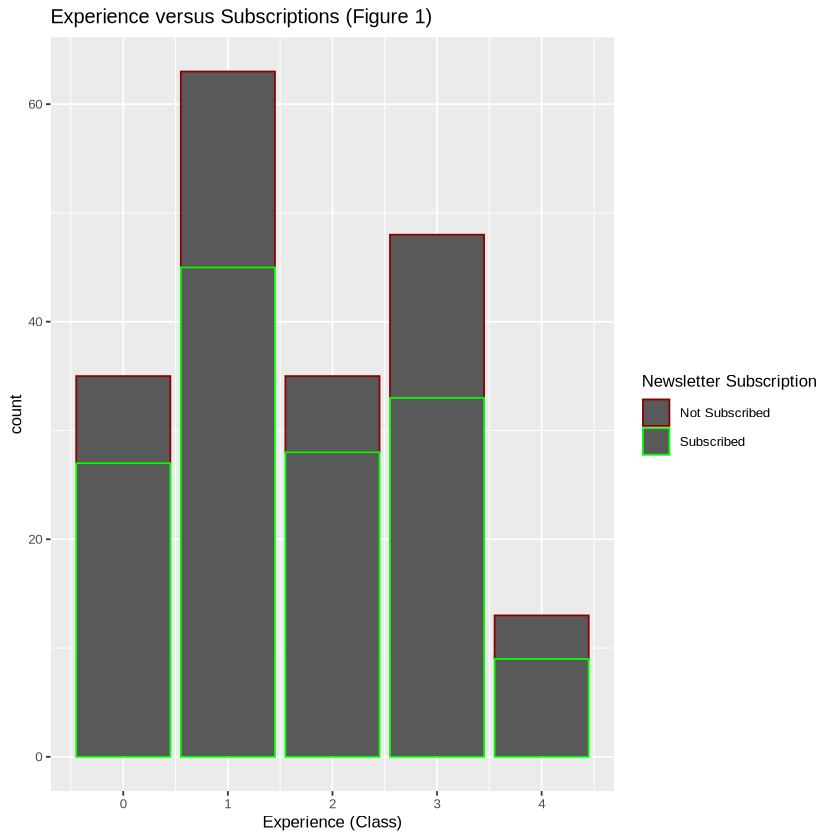

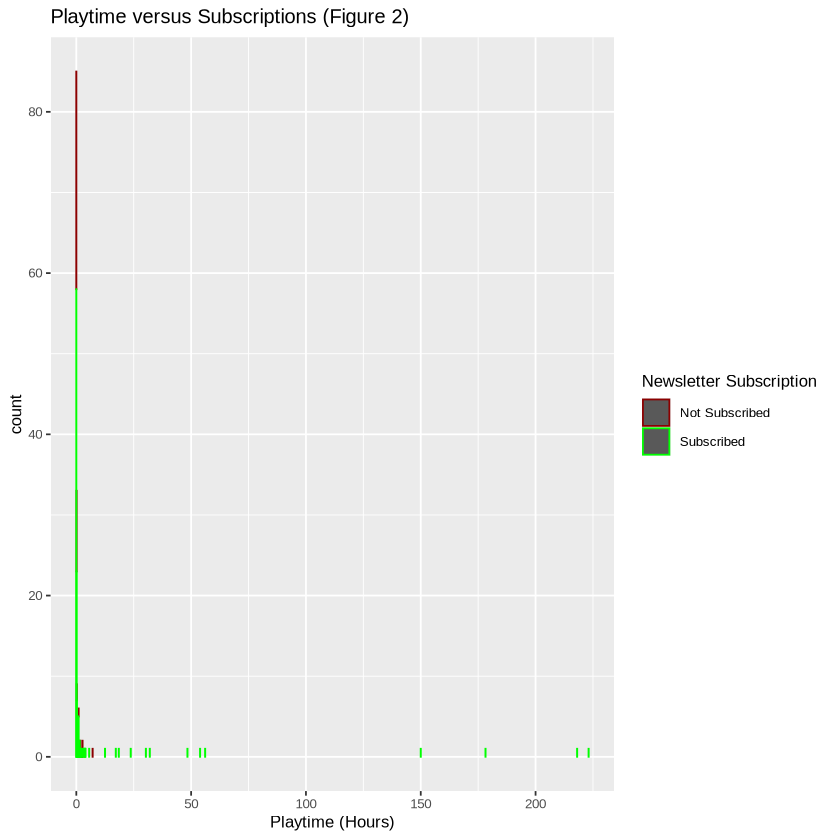

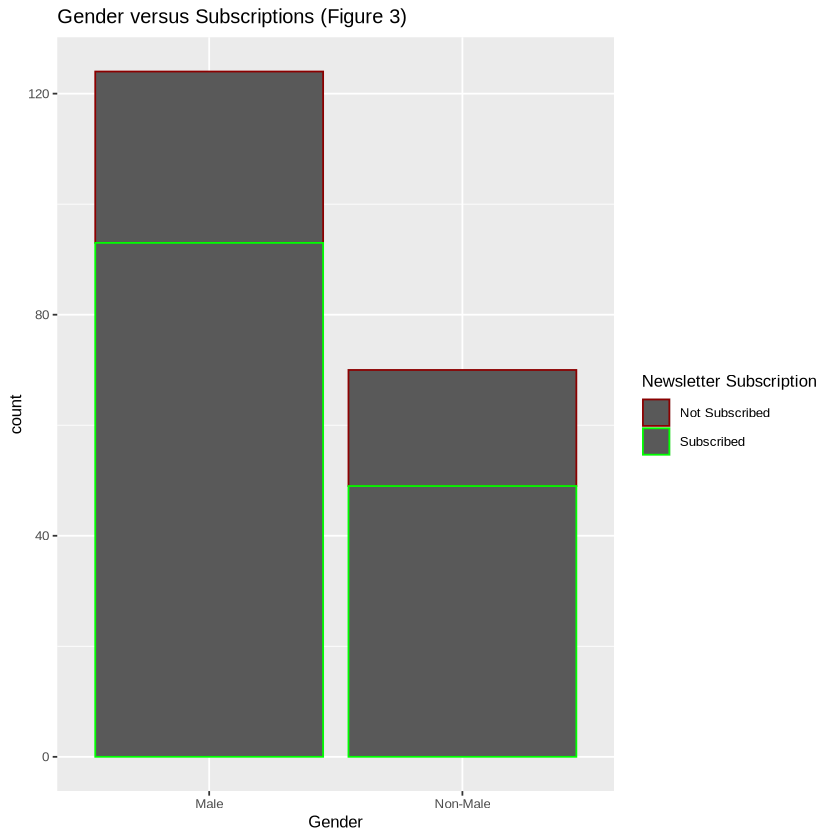

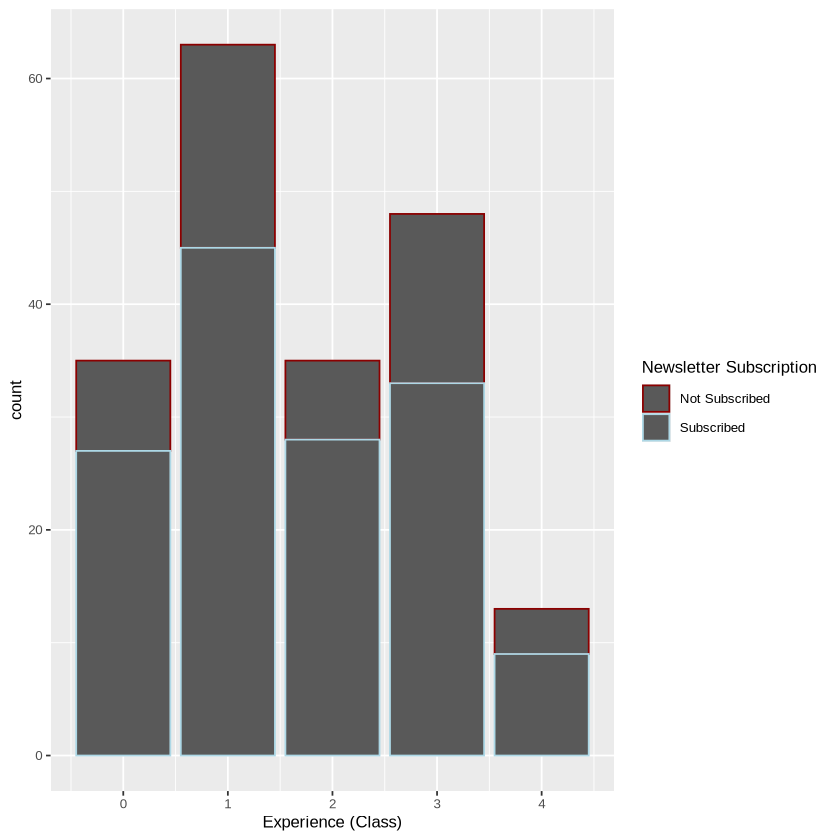

In [19]:
<<<<<<< REMOTE CELL DELETED >>>>>>>
#exploratory visualization/graphs

#Plotting experience versus subscriptions
exp_experience_plot <- players_data_wrangled|>
  ggplot(aes(x = experience, color = subscribe)) +
  geom_bar() +
  labs(x = "Experience (Class)",
       color = "Newsletter Subscription") +
  scale_color_manual(values = c("darkRed", "green")) +
ggtitle("Experience versus Subscriptions (Figure 1)") +
  theme(text = element_text(size = 10))

exp_experience_plot


#Plotting playtime versus subscriptions
exp_playtime_plot <- players_data_wrangled|>
  ggplot(aes(x = played_hours, color = subscribe)) +
  geom_bar() +
  labs(x = "Playtime (Hours)",
       color = "Newsletter Subscription") +
  scale_color_manual(values = c("darkRed", "green")) +
ggtitle("Playtime versus Subscriptions (Figure 2)") +
  theme(text = element_text(size = 10))

exp_playtime_plot


#Plotting gender versus subscriptions
exp_gender_plot <- players_data_wrangled|>
  ggplot(aes(x = gender, color = subscribe)) +
  geom_bar() +
  labs(x = "Gender",
       color = "Newsletter Subscription") +
  scale_color_manual(values = c("darkRed", "green")) +
ggtitle("Gender versus Subscriptions (Figure 3)") +
  theme(text = element_text(size = 10))

exp_gender_plot

#exploratory visualization/graphs

#Plotting experience versus subscriptions
experience_plot <- players_data_wrangled|>
  ggplot(aes(x = experience, color = subscribe)) +
  geom_bar() +
  labs(x = "Experience (Class)",
       color = "Newsletter Subscription") +
  scale_color_manual(values = c("darkRed", "lightblue")) +
  theme(text = element_text(size = 10))

experience_plot

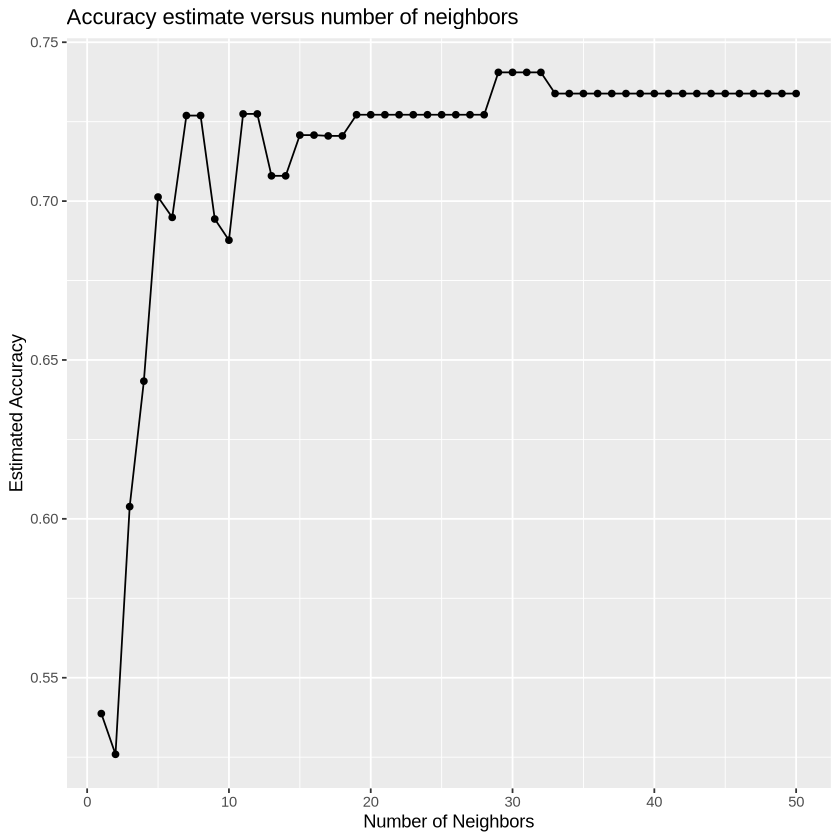

In [20]:
#analysis
set.seed(12345) #Do not change

#First split; 80% training, 20% testing
players_initial_split <- initial_split(players_data_wrangled, prop = 0.8, strata = subscribe)

players_testing <- testing(players_initial_split)
players_training <- training(players_initial_split)


#Selecting K by tuning
#recipe for tuning
players_recipe_tune <- recipe(subscribe ~ experience + played_hours + Age, data = players_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

#model specification for tuning
knn_spec_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

#K values to test
k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

#3 folds
players_vfold_3 <- vfold_cv(players_training, v = 3, strata = subscribe)

#Metrics for evaluation
vfold_metrics_3 <- workflow() |>
    add_recipe(players_recipe_tune) |>
    add_model(knn_spec_tune) |>
    tune_grid(resamples = players_vfold_3, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    select(neighbors, mean)

vfold_visual <- ggplot(vfold_metrics_3, aes(x = neighbors, y = mean)) +
    geom_point() + 
    geom_line() +
    ggtitle("Accuracy estimate versus number of neighbors") +
    labs(x = "Number of Neighbors", y = "Estimated Accuracy")
vfold_visual


In [ ]:
#visualization of analysis